# Previsão com ARIMA

In [678]:
#Pacotes
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams

## Base de Dados:

In [679]:
#Dados bruto
dados = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)
dados

,value
0,88
1,84
2,85
3,85
4,84
...,...
95,222
96,228
97,226
98,222


# Verificar estacionariedade dos dados

<AxesSubplot:>

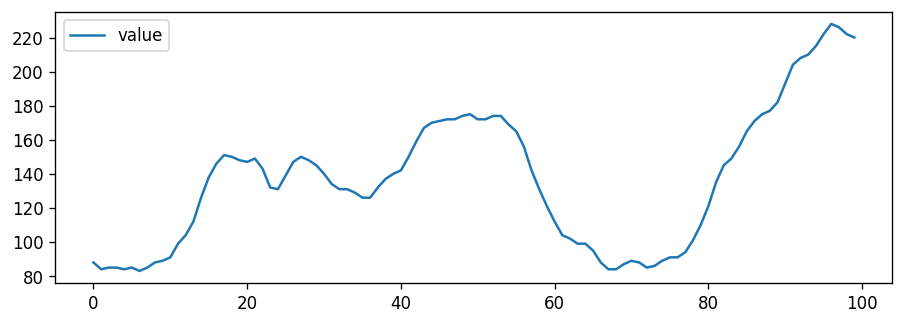

In [680]:
dados.plot()

<AxesSubplot:>

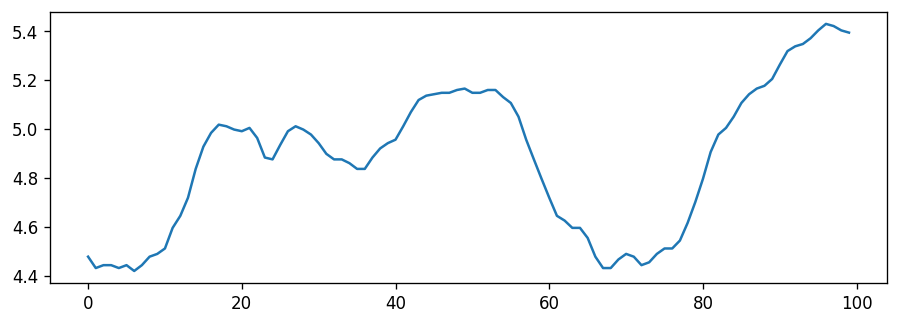

In [681]:
dados['Log'] = np.log(dados.value)
dados.Log.plot()

<AxesSubplot:>

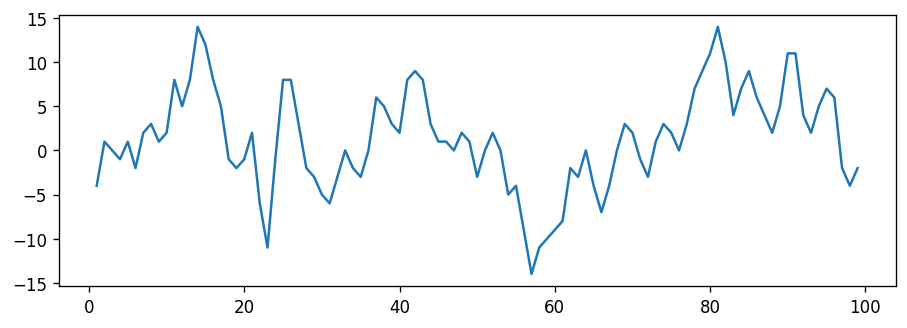

In [682]:
dados['Diff_1'] = dados.value.diff(1)
dados.Diff_1.plot()

<AxesSubplot:>

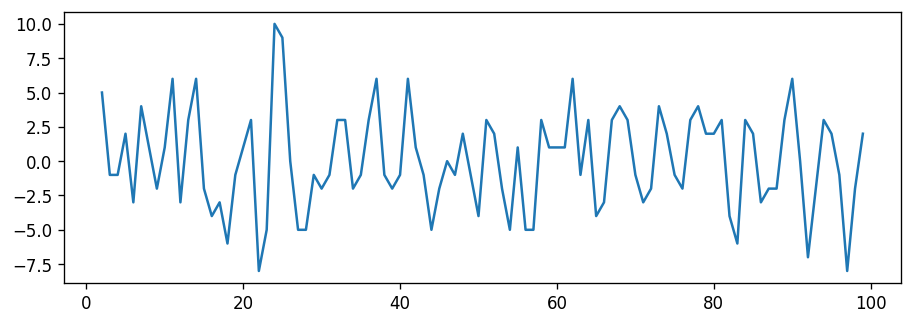

In [683]:
dados['Diff_2'] = dados.Diff_1.diff(1)
dados.Diff_2.plot()


In [684]:
dados1 = dados.iloc[1:,:]

In [686]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

adf_test(dados.iloc[1:,2])# Sem diferenciação

Results of Dickey-Fuller Test:
Test Statistic                 -2.722238
p-value                         0.070268
#Lags Used                      2.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64


In [687]:
#Numero de diferenciaçoes necessarias
from pmdarima.arima.utils import ndiffs
ndiffs(dados.value, test='adf') 

2

**Serie Estacionaria , sem tendencia e Sazonalidade**

## Verificar a distribuição dos dados

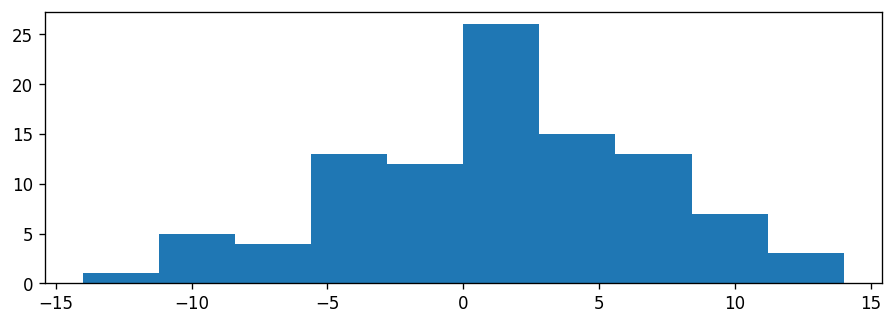

In [689]:
plt.hist(dados.Diff_1);

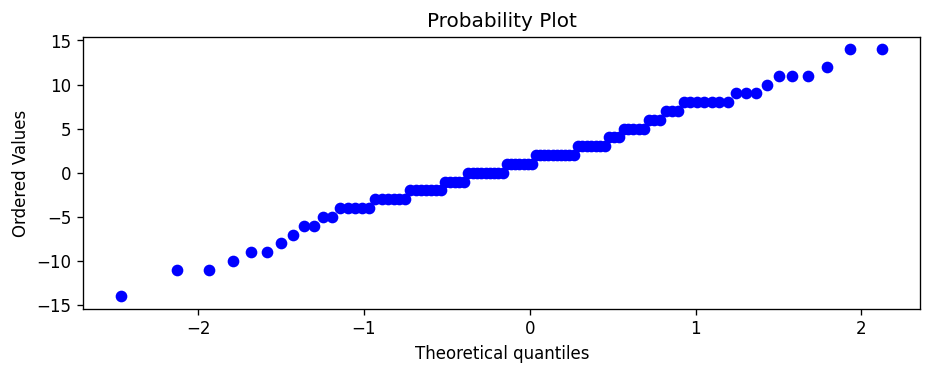

In [690]:
import scipy.stats as stats
stats.probplot(dados['Diff_1'], dist="norm", plot=plt)
plt.show()

In [691]:
from scipy import stats
shapiro_test = stats.shapiro(dados['Diff_1']);shapiro_test

ShapiroResult(statistic=nan, pvalue=1.0)

## Função de AutoCorrelação(FAC) apresenta um decaimento exponencial?

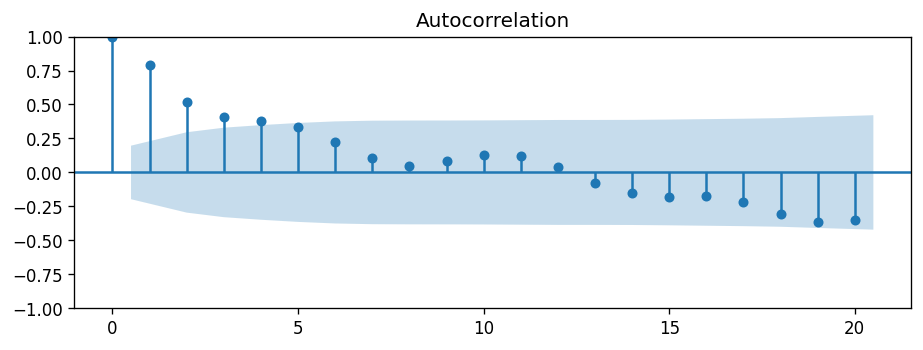

In [692]:
from statsmodels.graphics import tsaplots
fig = tsaplots.plot_acf(dados.Diff_1.dropna(),lags=20)

**Serie tem um comportamento ciclico porém com decaimento Exponencial**

## Verificar se a funçao de Autocorrelaçao Parcial apresenta um claro 'corte' na correlaçao em algum passo (p)


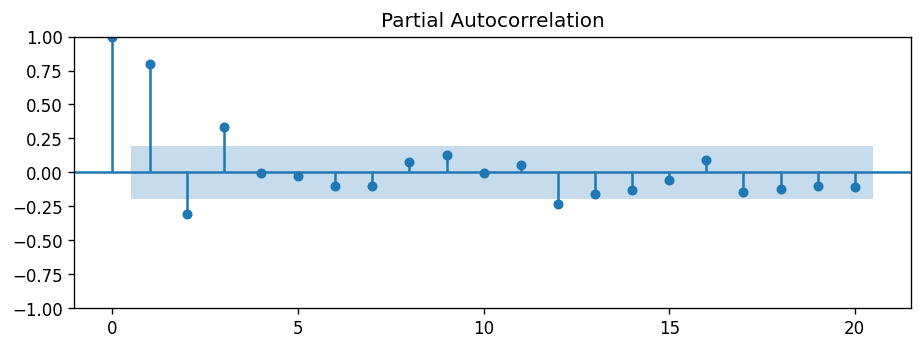

In [491]:
import warnings
warnings.filterwarnings('ignore')

fig = tsaplots.plot_pacf(dados.Diff_1.dropna(),lags=20);

In [706]:
from statsmodels.tsa.arima.model import ARIMA,sarimax
modelo = ARIMA(dados1.value,order =(1,1,1))
modelo_fit = modelo.fit()
print(modelo_fit.summary())



                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   99
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -251.061
Date:                Sun, 07 Nov 2021   AIC                            508.121
Time:                        14:10:13   BIC                            515.876
Sample:                             0   HQIC                           511.258
                                 - 99                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6570      0.088      7.482      0.000       0.485       0.829
ma.L1          0.5124      0.088      5.846      0.000       0.341       0.684
sigma2         9.6892      1.370      7.072      0.0

In [709]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(dados1.value, modelo_fit.fittedvalues))
rmse

8.992960882219398

<AxesSubplot:>

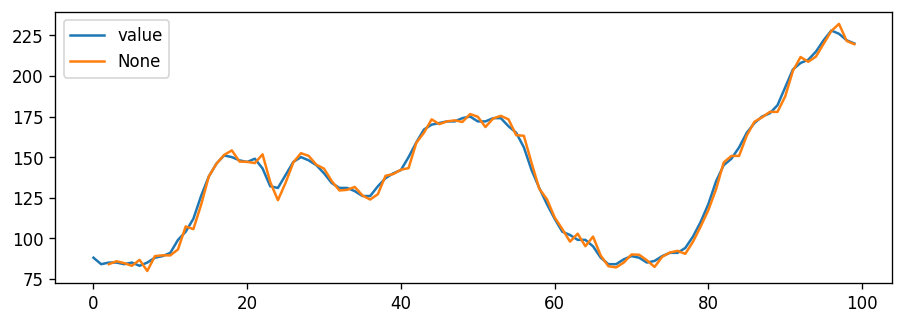

In [710]:

dados.value.plot(legend=True)
modelo_fit.fittedvalues[1:].plot(legend=True) 

In [711]:
dados1['predi']=modelo_fit.fittedvalues
dados1

,value,Log,Diff_1,Diff_2,predi
1,84,4.430817,-4.0,NaN,0.000000
2,85,4.442651,1.0,5.0,84.002239
3,85,4.442651,0.0,-1.0,85.807124
4,84,4.430817,-1.0,-1.0,84.651130
5,85,4.442651,1.0,2.0,83.022486
...,...,...,...,...,...
95,222,5.402677,7.0,2.0,219.842289
96,228,5.429346,6.0,-1.0,227.704871
97,226,5.420535,-2.0,-8.0,232.093429
98,222,5.402677,-4.0,-2.0,221.563590


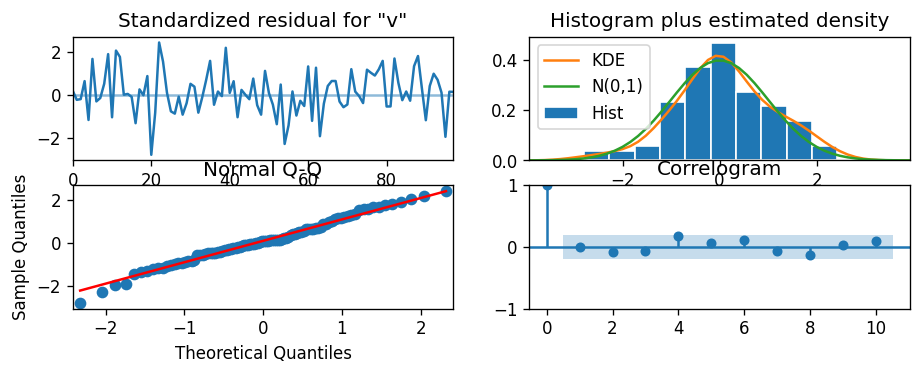

In [712]:
modelo_fit.plot_diagnostics()
plt.show()

# Treino e teste

In [734]:
# Create Training and Test
train = df.value[:75]
test = df.value[75:]

In [735]:
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit()  
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   75
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -190.947
Date:                Sun, 07 Nov 2021   AIC                            387.894
Time:                        14:20:09   BIC                            394.806
Sample:                             0   HQIC                           390.651
                                 - 75                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6048      0.112      5.420      0.000       0.386       0.824
ma.L1          0.4832      0.104      4.644      0.000       0.279       0.687
sigma2        10.0358      1.618      6.201      0.000       6.864      13.208
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.13
Prob(Q):                              0.97   Prob(JB):                         0.94
Heteroskedasticity (H):               0.64   Skew:                             0.09
Prob(H) (two-sided):                  0.28   Kurtosis:                         3.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Previsão com os dados de treino 

In [736]:
predicoes = fitted.get_prediction(start=-12) # Somente os ultimos 12 periodos
predicao_media =  predicoes.predicted_mean #Plotar a media
int_conf = predicoes.conf_int()
limite_baixo = int_conf.iloc[:,0]#Plotar intervalo de conf da banda de baixo
limite_acima = int_conf.iloc[:,1]#Plotar intervalo de conf da banda acima

In [737]:
datas_previstas = np.asanyarray(predicao_media.index) #Indice das  datas previstas
datas = np.asanyarray(dados.index) #Todas as datas


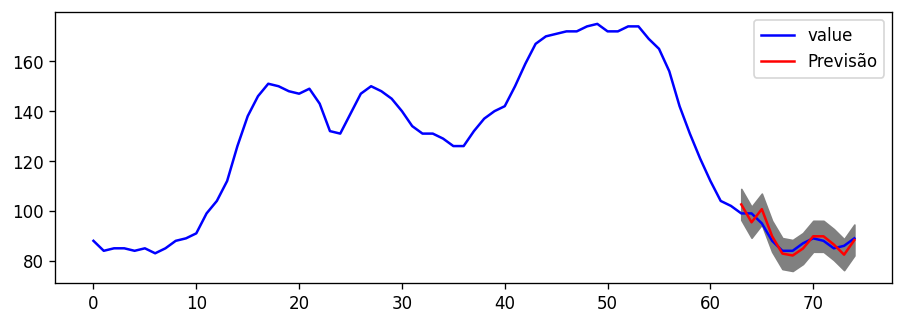

In [738]:
train.plot(legend=True,color='b')
plt.plot(datas_previstas,predicao_media.values,label='Previsão',color='r');
plt.fill_between(datas_previstas,limite_baixo,limite_acima,color='grey')
plt.legend();

In [741]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(train, fitted.fittedvalues))
rmse

10.64548230611509

## Dados de Teste

In [742]:
model = ARIMA(test, order=(1, 1, 1))  
fitted = model.fit()  
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   25
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -58.439
Date:                Sun, 07 Nov 2021   AIC                            122.879
Time:                        14:21:30   BIC                            126.413
Sample:                             0   HQIC                           123.816
                                 - 25                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7147      0.139      5.126      0.000       0.441       0.988
ma.L1          0.9998     65.916      0.015      0.988    -128.194     130.193
sigma2         6.2016    409.633      0.015      0.988    -796.664     809.068
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 1.13
Prob(Q):                              0.87   Prob(JB):                         0.57
Heteroskedasticity (H):               1.44   Skew:                            -0.49
Prob(H) (two-sided):                  0.62   Kurtosis:                         2.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

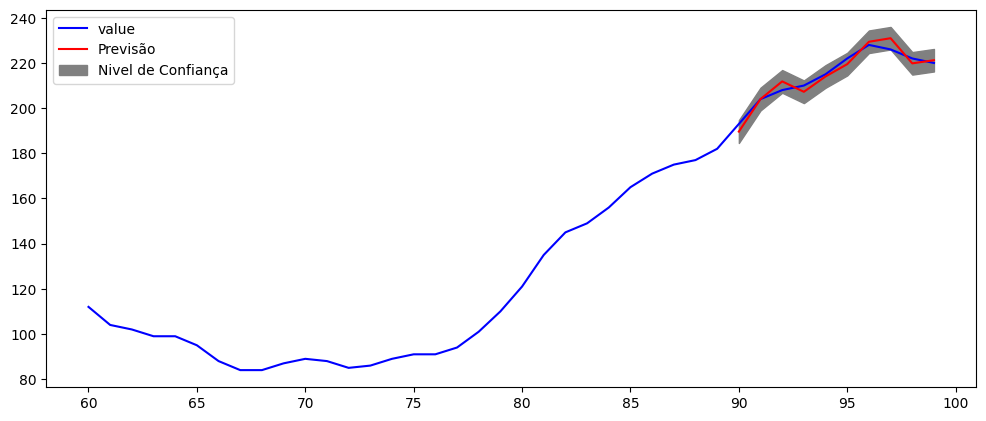

In [830]:
fc = fitted.get_prediction(-10, alpha=0.05)  # 95% conf
predicao_media =  fc.predicted_mean #Plotar a media

int_conf = fc.conf_int()
limite_baixo = int_conf.iloc[:,0]#Plotar intervalo de conf da banda de baixo
limite_acima = int_conf.iloc[:,1]#Plotar intervalo de conf da banda acima

datas_previstas = np.asanyarray(predicao_media.index) #Indice das  datas previstas
datas = np.asanyarray(dados.index) #Todas as datas
datas_previstas = np.asanyarray(predicao_media.index) #Indice das  datas previstas


plt.figure(figsize=(12,5), dpi=100)
dados.iloc[60:,0].plot(legend=True,color='b') #Filtrando os ultimos meses para verificar melhor a prediçao no grafico
plt.plot(datas_previstas,predicao_media.values,label='Previsão',color='r');
plt.fill_between(datas_previstas,limite_baixo,limite_acima,color='grey',label='Nivel de Confiança')
plt.legend()






In [752]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(test, fitted.fittedvalues))
rmse

18.38585308736363

## Previsão (ERRO)

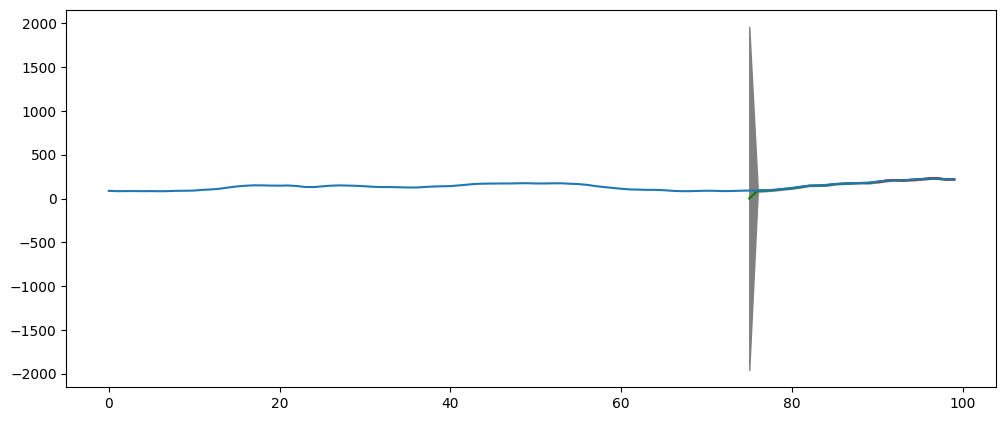

In [835]:
#Forecast para 12 periodos 
forecast = fitted.get_prediction(step=12)  # prever os ultimos 10 dias
forecast_medio =  forecast.predicted_mean#Plotar a media
forecast_medio.size

int_conf_forecast = forecast.conf_int()
limite_baixo_f = int_conf_forecast.iloc[:,0]#Plotar intervalo de conf da banda de baixo
limite_acima_f = int_conf_forecast.iloc[:,1]#Plotar intervalo de conf da banda acima

datas_forecast = np.asanyarray(forecast_medio.index) #Indice das  datas previstas
pred_dates = np.asanyarray(predicao_media.index) #Todas as datas
datas = np.asarray(dados.index)


plt.figure(figsize=(12,5), dpi=100)

plt.plot(datas_forecast,forecast_medio.values,label='Forecast',color='green');
plt.fill_between(datas_forecast,limite_baixo_f,limite_acima_f,color='grey',label='Nivel de Confiança')#ERRO

plt.plot(datas_previstas,predicao_media.values,label='Previsão',color='r');
plt.fill_between(datas_previstas,limite_baixo,limite_acima,color='grey',label='Nivel de Confiança')


plt.plot(datas,dados.value.values,label='Real')
plt.show()


## Auto-Arima

In [762]:
from pmdarima.arima import auto_arima
model = auto_arima(dados1.value,trace=True)  

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=512.445, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=621.418, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=524.383, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=542.732, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=625.164, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=510.994, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=512.507, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=509.135, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=511.114, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=516.361, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=508.121, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=544.731, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=522.961, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=510.121, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=510.1

In [763]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(dados1.value,order=(1,1,1),seasonal_order=(1,1,1,6))
resultado_sarimax = model.fit()
print(resultado_sarimax.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             value   No. Observations:                   99
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 6)   Log Likelihood                -243.569
Date:                           Sun, 07 Nov 2021   AIC                            497.139
Time:                                   14:28:20   BIC                            509.748
Sample:                                        0   HQIC                           502.228
                                            - 99                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6271      0.085      7.411      0.000       0.461       0.793
ma.L1          0.5471      0.101      5.426

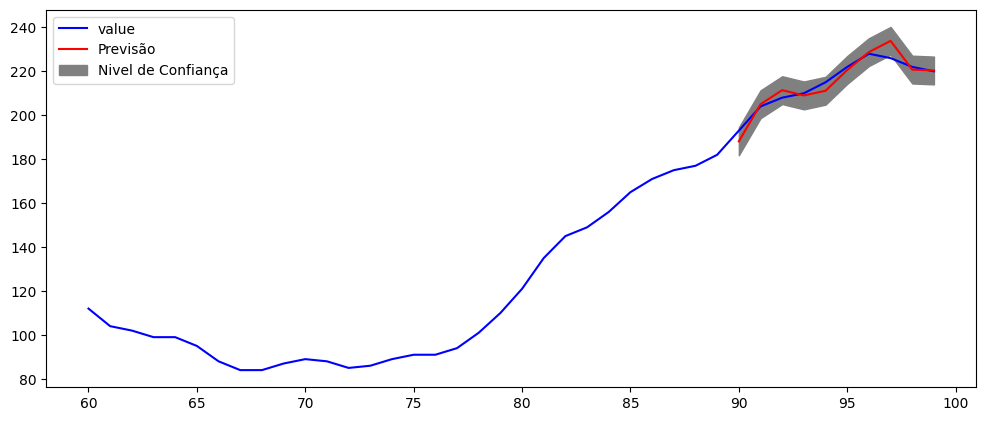

In [796]:
fc = resultado_sarimax.get_prediction(-10, alpha=0.05)  # prever os ultimos 10 dias
predicao_media =  fc.predicted_mean #Plotar a media

int_conf = fc.conf_int()
limite_baixo = int_conf.iloc[:,0]#Plotar intervalo de conf da banda de baixo
limite_acima = int_conf.iloc[:,1]#Plotar intervalo de conf da banda acima

datas_previstas = np.asanyarray(predicao_media.index) #Indice das  datas previstas
datas = np.asanyarray(dados.index) #Todas as datas



plt.figure(figsize=(12,5), dpi=100)
dados.iloc[60:,0].plot(legend=True,color='b') #Filtrando os ultimos meses para verificar melhor a prediçao no grafico
plt.plot(datas_previstas,predicao_media.values,label='Previsão',color='r');
plt.fill_between(datas_previstas,limite_baixo,limite_acima,color='grey',label='Nivel de Confiança')
plt.legend()

In [777]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(dados1.value[-10:], predicao_media.values))
rmse

3.435981077672974

## forecast  (erro nesta parte)

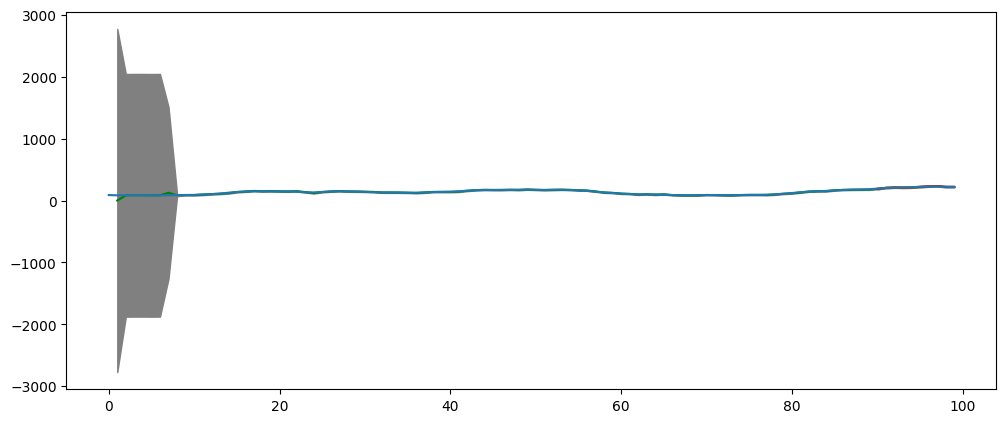

In [829]:
#Forecast para 12 periodos 
forecast = resultado_sarimax.get_prediction(step=12)  # prever os ultimos 10 dias
forecast_medio =  forecast.predicted_mean#Plotar a media
forecast_medio.size

int_conf_forecast = forecast.conf_int()
limite_baixo_f = int_conf_forecast.iloc[:,0]#Plotar intervalo de conf da banda de baixo
limite_acima_f = int_conf_forecast.iloc[:,1]#Plotar intervalo de conf da banda acima

datas_forecast = np.asanyarray(forecast_medio.index) #Indice das  datas previstas
pred_dates = np.asanyarray(predicao_media.index) #Todas as datas
datas = np.asarray(dados.index)


plt.figure(figsize=(12,5), dpi=100)

plt.plot(datas_forecast,forecast_medio.values,label='Forecast',color='green');
plt.fill_between(datas_forecast,limite_baixo_f,limite_acima_f,color='grey',label='Nivel de Confiança')

plt.plot(datas_previstas,predicao_media.values,label='Previsão',color='r');
plt.fill_between(datas_previstas,limite_baixo,limite_acima,color='grey',label='Nivel de Confiança')


plt.plot(datas,dados.value.values,label='Real')
plt.show()



In [428]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

dta = sm.datasets.sunspots.load_pandas().data[['SUNACTIVITY']]
dta.index = pd.DatetimeIndex(pd.date_range('1700',freq='Y',periods=309))
res = ARIMA(dta,order = (3,0,0)).fit()
res.

In [429]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            SUNACTIVITY   No. Observations:                  309
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -1304.702
Date:                Sat, 06 Nov 2021   AIC                           2619.404
Time:                        09:38:28   BIC                           2638.070
Sample:                    12-31-1700   HQIC                          2626.867
                         - 12-31-2008                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.7519      3.518     14.141      0.000      42.856      56.648
ar.L1          1.3008      0.050     25.763      0.000       1.202       1.400
ar.L2         -0.5081      0.079     -6.421      0.000      -0.663      -0.353
ar.L3         -0.1296      0.058     -2.236      0.025      -0.243      -0.016
sigma2       270.1011     18.599     14.523      0.000     233.649     306.554
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               105.66
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.55   Skew:                             0.92
Prob(H) (two-sided):                  0.03   Kurtosis:                         5.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""